<a href="https://colab.research.google.com/github/sachinmkotian/CloudxLabs_sachin_2024/blob/main/Sachin_Assignment_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

df = pd.read_csv("/content/amazon_review_small.txt")

In [ ]:
#There are no column names for the data so add column names.
df.columns = ['Rating', 'Summary','Review']
df= df.drop(columns=['Summary'])

#Need to remove rows that don't have values
df = df.dropna(subset=["Rating","Review"])

,Rating,Review
0,4,This is a fast read filled with unexpected hum...
1,2,I bought one of these chargers..the instructio...
2,2,I was excited to find a book ostensibly about ...
3,2,"I am a big JVC fan, but I do not like this mod..."
4,2,"I love the style of this, but after a couple y..."


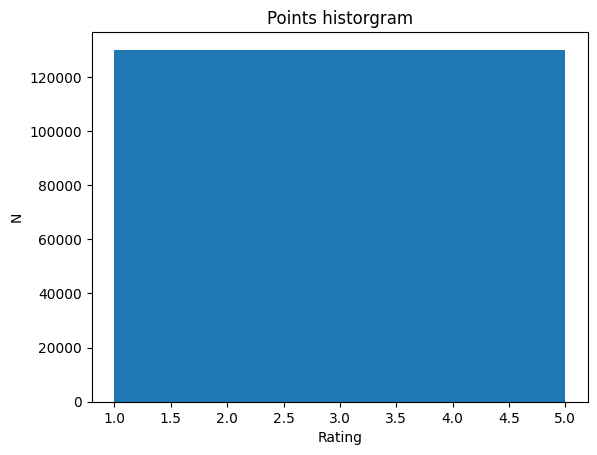

In [ ]:
plt.hist(df.Rating,bins=5)
plt.title("Points historgram")
plt.xlabel("Rating")
plt.ylabel("N")
plt.show()

In [57]:
#Making Rating Postive and negative ratings...i.e. if rating >= 3 its positive else negative.
df["Label"] = (df.Rating >= 3).astype(int)
df = df[["Rating","Review","Label"]]
df.head()


,Rating,Review,Label
0,4,This is a fast read filled with unexpected hum...,1
1,2,I bought one of these chargers..the instructio...,0
2,2,I was excited to find a book ostensibly about ...,0
3,2,"I am a big JVC fan, but I do not like this mod...",0
4,2,"I love the style of this, but after a couple y...",0


In [58]:
#Make training data as 90% and remaining 10% as Test
train,test,validate = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])
len(train),len(test),len(validate)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(519999, 65000, 65000)

In [59]:
def df_to_dataset(dataframe, shuffle=True, batch_size=5000):
    df = dataframe.copy()
    lables = df.pop('Label')
    df = df["Review"]
    ds = tf.data.Dataset.from_tensor_slices((df, lables))
    if shuffle:
      ds = ds.shuffle(buffer_size = len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [60]:
train_data = df_to_dataset(train)
test_data = df_to_dataset(test)
validate_data = df_to_dataset(validate)

In [61]:
list(train_data)[0]

(<tf.Tensor: shape=(5000,), dtype=string, numpy=
 array([b'Though the movie does have some redeeming qualities with its cinematography; it lacks a decent story line, it is kill, kill and more kill from beginning to end. I am not sure what I expected but it is not worth the two hours.',
        b'I like this book only because it had more than activities in it then expected. I did find a few activities mention in the book to not be age developmental appropriate',
        b"This thing is awful, we asked for a coffee, espresso, cappucino etc. machine for Christmas last year, so my grandparents gave us $100 to purchase on because they didn't know which one to get. We didn't do research and thought Delonghi was a great brand, well needless to say we unfortunately blew our 100 on this piece of crap. The directions are SO complicated, we were never able to froth milk or anything all we could do was make a leaky pot of coffee! I wouldn't pay a dime for this thing, it's bulky and junky, splurge 

In [62]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer= hub.KerasLayer(embedding, dtype=tf.string,trainable=True)
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(5000, 50), dtype=float32, numpy=
array([[ 0.4362212 ,  0.18873829,  0.14930438, ..., -0.24153714,
         0.27207008,  0.19118235],
       [ 0.07442515,  0.39173457, -0.13472772, ..., -0.15737695,
         0.17257147,  0.05833896],
       [ 0.42569432, -0.33578688, -0.15165892, ...,  0.00610261,
         0.13452037,  0.07857103],
       ...,
       [ 0.5150243 ,  0.13415185,  0.06291752, ..., -0.22539426,
         0.00576698,  0.1598758 ],
       [ 0.44517505,  0.09883557, -0.21377741, ..., -0.28649083,
         0.34202284,  0.15399455],
       [ 0.6657946 , -0.52924407,  0.09767932, ..., -0.24218746,
        -0.22157851,  0.30684054]], dtype=float32)>

In [63]:
model = tf_keras.Sequential()
model.add(hub_layer)
model.add(tf_keras.layers.Dense(16,activation='relu'))
model.add(tf_keras.layers.Dropout(0.4))
model.add(tf_keras.layers.Dense(16,activation='relu'))
model.add(tf_keras.layers.Dropout(0.4))
model.add(tf_keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),loss=tf_keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

model.evaluate(train_data)
model.evaluate(validate_data)

13/13 [==============================] - 1s 82ms/step - loss: 0.6859 - accuracy: 0.5775


[0.6858906745910645, 0.5774615406990051]

In [64]:
history = model.fit(train_data,epochs=5,validation_data=validate_data)

Epoch 1/5
104/104 [==============================] - 162s 2s/step - loss: 0.6126 - accuracy: 0.6518 - val_loss: 0.4913 - val_accuracy: 0.7739
Epoch 2/5
104/104 [==============================] - 161s 2s/step - loss: 0.4850 - accuracy: 0.7745 - val_loss: 0.4328 - val_accuracy: 0.7962
Epoch 3/5
104/104 [==============================] - 162s 2s/step - loss: 0.4397 - accuracy: 0.8037 - val_loss: 0.4227 - val_accuracy: 0.7979
Epoch 4/5
104/104 [==============================] - 163s 2s/step - loss: 0.4161 - accuracy: 0.8158 - val_loss: 0.4228 - val_accuracy: 0.7986
Epoch 5/5
104/104 [==============================] - 166s 2s/step - loss: 0.4002 - accuracy: 0.8237 - val_loss: 0.4261 - val_accuracy: 0.7985


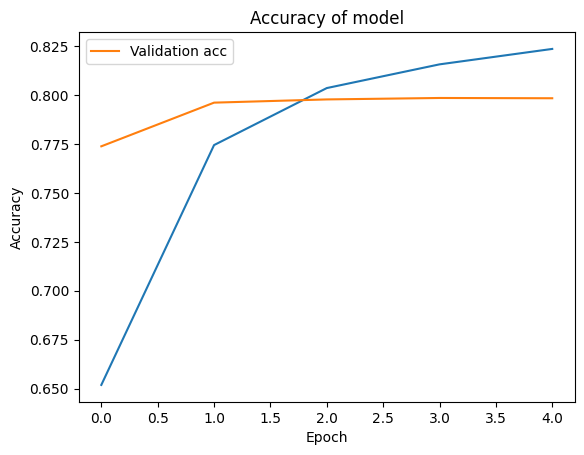

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],label='Validation acc')
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [66]:
model.evaluate(test_data)

13/13 [==============================] - 4s 326ms/step - loss: 0.4253 - accuracy: 0.7999


[0.4253469705581665, 0.7998769283294678]